<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/S11-Assignment/S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive/S11-Assignment/')
!ls /content/gdrive/My\ Drive/S11-Assignment

dataloader.py	    grad_cam.py       Models	       S10-graph.png
Data_Transforms     __init__.py       one_cycle.py     S10.ipynb
data_transforms.py  lr_finder.py      README.md        utils.py
eval.py		    misclassified.py  S10-GradCam.pdf


In [3]:
%cd /content/gdrive/My Drive/S11-Assignment/

/content/gdrive/My Drive/S11-Assignment


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [5]:
cd /content/gdrive/My Drive/S11-Assignment/

/content/gdrive/My Drive/S11-Assignment


RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)

In [6]:
from Data_Transforms import transform

import importlib
importlib.reload(transform)

#from transform  import Data
data = transform.Data()

trainset = data.getTrainDataSetTorchTransforms(train=True)
testset =  data.getTestDataSetTorchTransforms(train=False)
trainloader = data.getDataLoader(trainset, 512)
testloader = data.getDataLoader(testset, 512)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


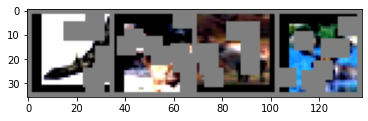

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import utils

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
utils.imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:

import torch
from Models import customresnet
!pip install torchsummary
from torchsummary import summary

model = customresnet.CustomResNet()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(model.device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


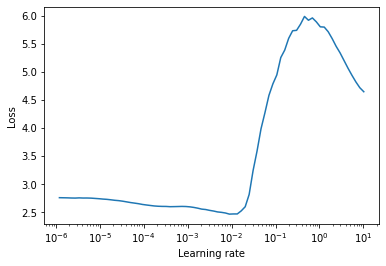

In [9]:
from lr_finder import LRFinder

import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import StepLR


EPOCHS = 24
l2_loss = 0.0001
l1_lambda = 0
criterion = nn.CrossEntropyLoss()

#Optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=l2_loss)

#LR Finder
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

We'll use method described in paper : https://arxiv.org/abs/1506.01186 to find out optimum learning rate.
We'll increase the learning rate from lower value per iteration for some iterations till loss starts exploding.
We'll plot loss vs learning rate plot.
We'll then select learning rate that is one power higher than the one where loss is minimum
This value can be used as maximum value in Cyclic Learning Rate policy and minimum learning rate
can be set to 1/3, 1/4th of max value.



In [11]:
#Find the min loss from lr finder
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
print(min(loss))
print(lr[loss.index(min(loss))])


2.461919366115495
0.008912509381337464


LR MAX and MIN 

In [0]:
LRMAX = 0.08
LRMIN = 0.01

Train using Once Cycle learning , max to be at 5th epoch, hence percent is set to 60 %

In [13]:
import one_cycle as OneCycle
from torch.optim.lr_scheduler import ReduceLROnPlateau

onecycle = OneCycle.OneCycle(int(len(trainset) * EPOCHS / 512), LRMAX, prcnt=60, momentum_vals=(0.95, 0.8))

optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=l2_loss)

schedular = None
model.evaluate(optimizer, trainloader, testloader, EPOCHS, criterion, onecycle, schedular, False, l1_lambda)

Epoch= 0 Loss=2.0661842823028564 Batch_id=97 Accuracy=27.08: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 0, Train Accuracy: 27.083333333333332 , Test Accuracy: 28.96


Epoch= 1 Loss=1.6797422170639038 Batch_id=97 Accuracy=42.56: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1, Train Accuracy: 42.55952380952381 , Test Accuracy: 33.72


Epoch= 2 Loss=1.5118776559829712 Batch_id=97 Accuracy=52.68: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2, Train Accuracy: 52.67857142857143 , Test Accuracy: 50.94


Epoch= 3 Loss=1.412589430809021 Batch_id=97 Accuracy=58.93: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3, Train Accuracy: 58.92857142857143 , Test Accuracy: 51.71


Epoch= 4 Loss=1.2600691318511963 Batch_id=97 Accuracy=63.99: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4, Train Accuracy: 63.98809523809524 , Test Accuracy: 58.62


Epoch= 5 Loss=1.1394124031066895 Batch_id=97 Accuracy=68.45: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5, Train Accuracy: 68.45238095238095 , Test Accuracy: 64.92


Epoch= 6 Loss=1.0459935665130615 Batch_id=97 Accuracy=71.43: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6, Train Accuracy: 71.42857142857143 , Test Accuracy: 69.18


Epoch= 7 Loss=0.9267125725746155 Batch_id=97 Accuracy=72.32: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7, Train Accuracy: 72.32142857142857 , Test Accuracy: 72.19


Epoch= 8 Loss=0.9266047477722168 Batch_id=97 Accuracy=73.21: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8, Train Accuracy: 73.21428571428571 , Test Accuracy: 73.15


Epoch= 9 Loss=0.9841095805168152 Batch_id=97 Accuracy=69.94: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9, Train Accuracy: 69.94047619047619 , Test Accuracy: 72.88


Epoch= 10 Loss=0.8443700075149536 Batch_id=97 Accuracy=71.13: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10, Train Accuracy: 71.13095238095238 , Test Accuracy: 76.72


Epoch= 11 Loss=0.7908453941345215 Batch_id=97 Accuracy=76.49: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11, Train Accuracy: 76.48809523809524 , Test Accuracy: 78.87


Epoch= 12 Loss=0.6290776133537292 Batch_id=97 Accuracy=79.17: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12, Train Accuracy: 79.16666666666667 , Test Accuracy: 80.57


Epoch= 13 Loss=0.8472787141799927 Batch_id=97 Accuracy=75.00: 100%|██████████| 98/98 [00:51<00:00,  1.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13, Train Accuracy: 75.0 , Test Accuracy: 81.05


Epoch= 14 Loss=0.6222550272941589 Batch_id=97 Accuracy=80.65: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14, Train Accuracy: 80.6547619047619 , Test Accuracy: 82.14


Epoch= 15 Loss=0.6071344017982483 Batch_id=97 Accuracy=81.25: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15, Train Accuracy: 81.25 , Test Accuracy: 84.51


Epoch= 16 Loss=0.6282655596733093 Batch_id=97 Accuracy=78.57: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16, Train Accuracy: 78.57142857142857 , Test Accuracy: 85.04


Epoch= 17 Loss=0.5891295075416565 Batch_id=97 Accuracy=83.04: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17, Train Accuracy: 83.03571428571429 , Test Accuracy: 85.09


Epoch= 18 Loss=0.6115382313728333 Batch_id=97 Accuracy=78.57: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18, Train Accuracy: 78.57142857142857 , Test Accuracy: 86.05


Epoch= 19 Loss=0.5400260090827942 Batch_id=97 Accuracy=82.74: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19, Train Accuracy: 82.73809523809524 , Test Accuracy: 87.03


Epoch= 20 Loss=0.5609620213508606 Batch_id=97 Accuracy=80.65: 100%|██████████| 98/98 [00:51<00:00,  1.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20, Train Accuracy: 80.6547619047619 , Test Accuracy: 87.14


Epoch= 21 Loss=0.4697414040565491 Batch_id=97 Accuracy=85.12: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 21, Train Accuracy: 85.11904761904762 , Test Accuracy: 87.28


Epoch= 22 Loss=0.44548267126083374 Batch_id=97 Accuracy=86.61: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 22, Train Accuracy: 86.60714285714286 , Test Accuracy: 88.45


Epoch= 23 Loss=0.3417850136756897 Batch_id=97 Accuracy=89.58: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]
100%|██████████| 20/20 [00:02<00:00,  8.21it/s]

Epoch 23, Train Accuracy: 89.58333333333333 , Test Accuracy: 88.83


Total number of iterations

In [14]:
print(int(len(trainset) * EPOCHS / 512))

2343


Plot the traingle for one cycle 

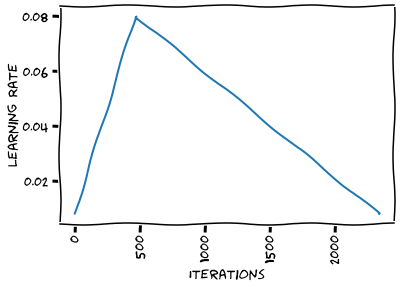

In [15]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=500), rotation=90)
plt.plot(onecycle.lrs[:2343])
plt.savefig('onecycle_lr.jpg')

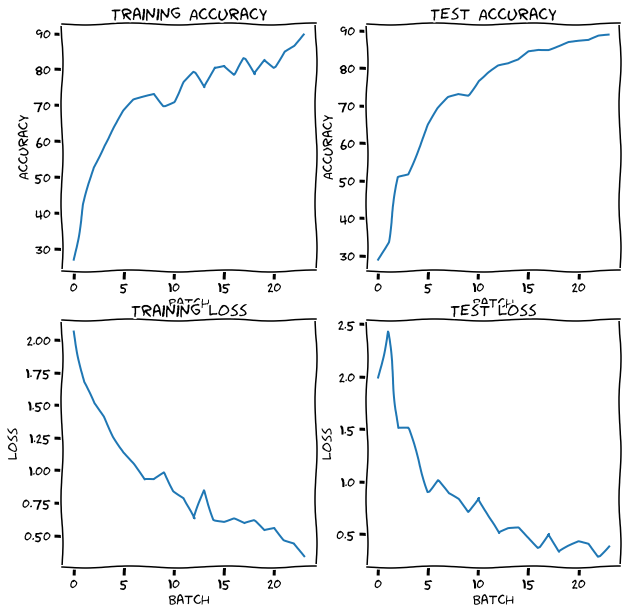

In [16]:
#Plot the graph
model.trainer.plot_graph()